<a href="https://colab.research.google.com/github/romainjulian/MEMOIRE_BELARBI_JULIAN/blob/master/M%C3%A9moire_BELARBI_JULIAN_PART_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART 2: LSTM Modèles vs ARIMA**

Programme ayant pour but d'impélmenter un RNN appelé LSTM afin de prévoir les cours de clotures ajusté des dividendes ('Adj Close') de l'action LVMH en utilisant les données historiques des cotations. 
Ensuite, nous comparerons ces prédictions avec des predictions obtens avec unn modèle plus traditional: l'ARIMA

In [0]:
#Import packages/libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


# **Préparation des données**

In [0]:
# Importation des données
LVMH= web.get_data_yahoo("MC.PA", "2012-01-1", "2019-12-31").reset_index()
Date=LVMH['Date'].iloc[1:,].reset_index(drop=True)

Text(0.5, -0.3, 'LVMH Daily closing stock prices between 2012 & 2020')

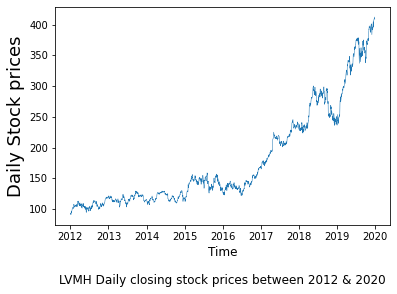

In [0]:
# Graph
plt.clf
plt.plot(LVMH['Date'],LVMH['Adj Close'],lw=.5)
plt.xlabel("Time",fontsize=12)
plt.ylabel("Daily Stock prices",fontsize=18)
plt.title("LVMH Daily closing stock prices between 2012 & 2020", fontdict=None, loc='center', y=-0.3)

In [0]:
# Selection des prix de clôture ajsutés
data=LVMH.filter(['Adj Close'])
dataset=data.values
dataset

array([[ 92.95439911],
       [ 93.62223053],
       [ 92.57875061],
       ...,
       [412.2706604 ],
       [409.30895996],
       [408.9140625 ]])

In [0]:
# Echelonnage des données entre 0 et 1
dataset = dataset.astype('float32')
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

scaled_data

array([[0.00636438],
       [0.00844252],
       [0.00519547],
       ...,
       [1.        ],
       [0.99078393],
       [0.9895551 ]], dtype=float32)

In [0]:
# Constitution du sous-jeu d'entraînement à partir des 80% premières observations
training_data_len=math.ceil(len(dataset)*.8)

train_data=scaled_data[0:training_data_len,:]

x_train=[]
y_train=[]

# La quantité d'observations passées prises en compte 
stock_history = 60

# x_train = historique à l'observation i - 1 (cf. range(3) -> 0,1,2)
# y_train = observation i à prévoir
for i in range (stock_history, len(train_data)):
  x_train.append(train_data[i-stock_history:i,0])
  y_train.append(train_data[i,0])

  # affichage des 2 premiers échantillons
  if i<=stock_history+1:
    print(x_train)
    print(y_train)
  
  # x_train est de la forme: 1575 blocs d'historique de 60 observations chacun
  # y_train enregistre les 1575 valeurs à prévoir

[array([0.00636438, 0.00844252, 0.00519547, 0.00272763, 0.        ,
       0.00298741, 0.01636547, 0.01220912, 0.01402754, 0.01272866,
       0.02117118, 0.02156082, 0.02376881, 0.02935392, 0.0302631 ,
       0.0302631 , 0.02987337, 0.03156191, 0.03792617, 0.03545839,
       0.03143197, 0.03818595, 0.04649857, 0.04545945, 0.05299276,
       0.05130428, 0.04260203, 0.03844574, 0.03883535, 0.03831586,
       0.04026416, 0.04195258, 0.04558936, 0.04208246, 0.04260203,
       0.04766753, 0.04857665, 0.04468015, 0.04831696, 0.0453296 ,
       0.0410434 , 0.04584914, 0.04519972, 0.05169392, 0.0526031 ,
       0.0511744 , 0.04078364, 0.04429051, 0.05481112, 0.05403179,
       0.0611755 , 0.06676048, 0.06416276, 0.06779954, 0.06883851,
       0.06702024, 0.05870765, 0.06039616, 0.05182382, 0.05052501],
      dtype=float32)]
[0.05403179]
[array([0.00636438, 0.00844252, 0.00519547, 0.00272763, 0.        ,
       0.00298741, 0.01636547, 0.01220912, 0.01402754, 0.01272866,
       0.02117118, 0.021

In [0]:
# Conversion en np.array car plus maniables que des listes
x_train,y_train=np.array(x_train),np.array(y_train)

# Redimension de x_train en 3D (1575 historiques de 60 observations chacun pour 1 feature (le prix))
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1575, 60, 1)

# **Définition du modèle**

In [0]:
# Définission du modèle
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [0]:
# Fonctions du modèle
model.compile(optimizer='adam',loss='mean_squared_error')

# **Entraînement**

In [0]:
# Entraînement
model.fit(x_train,y_train,batch_size=1, epochs=1)

Epoch 1/2
1575/1575 [==============================] - 57s 36ms/step - loss: 2.4353e-04
Epoch 2/2
1575/1575 [==============================] - 58s 37ms/step - loss: 1.8432e-04


# **Test**

In [0]:
# Constitution du sous-jeu test sur les 20% restants du jeu principal 
test_data=scaled_data[training_data_len - stock_history:,:]

# x_test = historique à l'observation i - 1 
# y_test = observation i à prévoir
x_test=[]
y_test=dataset[training_data_len:,:]

for i in range (stock_history,len(test_data)):
  x_test.append(test_data[i-stock_history:i,0])

In [0]:
# Conversion en array
x_test=np.array(x_test)

# Redimension de x_train en 3D
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(408, 60, 1)

In [0]:
# Prediction et re-échelonnage de nos données
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

In [0]:
# RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

23.839345932006836

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


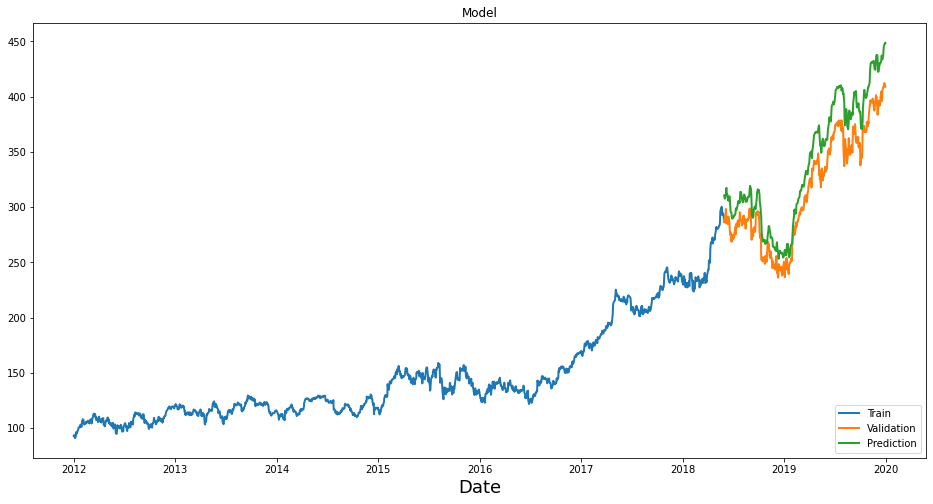

In [0]:
# Stockage des valeurs
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.plot(LVMH['Date'][:training_data_len],train['Adj Close'],lw=2)
plt.plot(LVMH['Date'][training_data_len:],valid[['Adj Close','Predictions']],lw=2)
plt.legend(['Train','Validation','Prediction'],loc='lower right')
plt.show()

In [0]:
# Valeurs exactes et prédictions
valid

,Adj Close,Predictions
1635,288.541077,310.569061
1636,286.132904,309.079590
1637,290.804688,307.563873
1638,293.309143,308.824982
1639,298.221710,311.520782
...,...,...
2038,408.815338,442.020203
2039,408.815338,445.309204
2040,412.270660,446.758942
2041,409.308960,448.755219


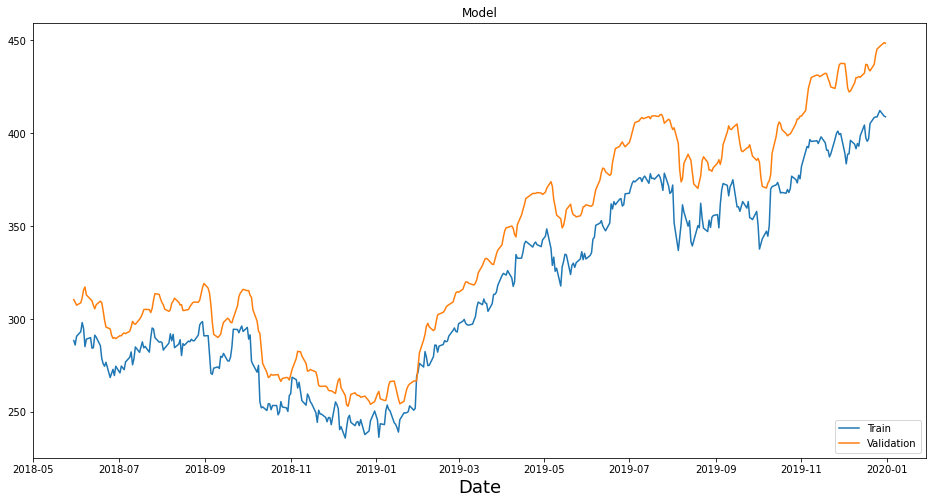

In [0]:
# Zoom du la zone de test
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.plot(LVMH['Date'][training_data_len:],valid[['Adj Close','Predictions']])
plt.legend(['Train','Validation','Prediction'],loc='lower right')
plt.show()

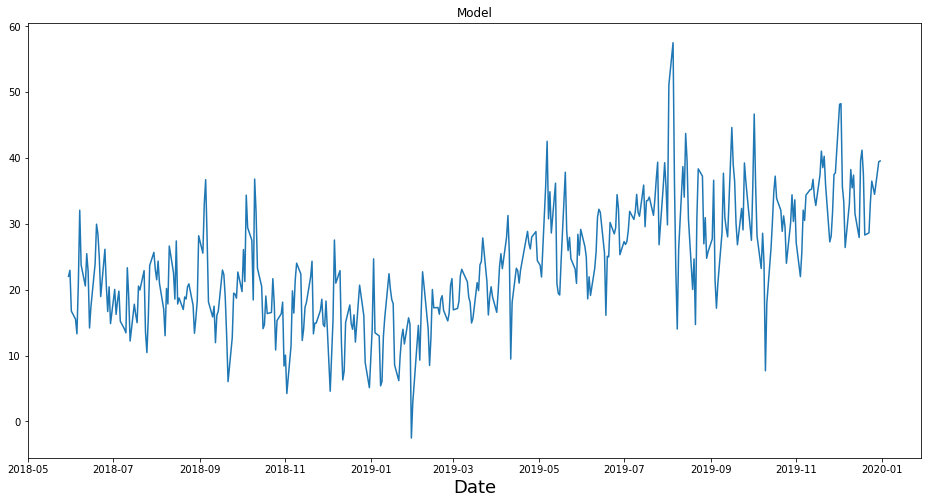

In [0]:
# Erreur: spread entre prdicitions et vrais valeurs
# Erreur positive notable en 2018 et 2019 à la suite d'une baisse des marchés financiers 
spread_LSTM=valid['Predictions']-valid['Adj Close']
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.plot(LVMH['Date'][training_data_len:],spread_LSTM)
plt.show()

# ARMA

# **Préparation des données**

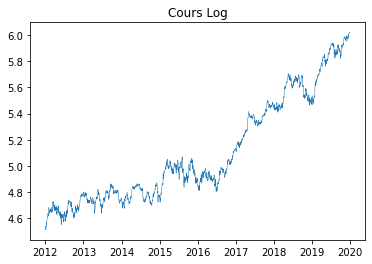

In [0]:
# Graph des cours logarithmés
serie_ln=np.log(LVMH['Adj Close'])
plt.plot(LVMH['Date'], serie_ln, lw=.5)
plt.title('Cours Log')
plt.show()

In [0]:
# Importation des packages nécessaires
from statsmodels.tsa.stattools import acf, pacf
from scipy.ndimage.interpolation import shift
from statsmodels.tsa.arima_model import ARIMA

0      -0.004049
1      -0.019812
2      -0.018199
3       0.000909
4       0.056240
          ...   
2036    0.008732
2037    0.000725
2038    0.008417
2039    0.001207
2040   -0.008175
Name: Adj Close, Length: 2041, dtype: float64

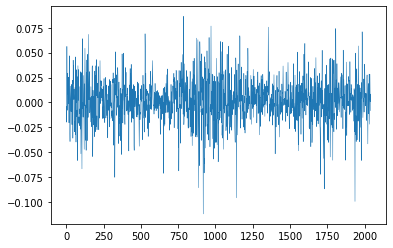

In [0]:
# Différenciation de la série afin de la rendre stationnaire
n_diff = 2
train_x_diff = serie_ln - shift(serie_ln, n_diff, cval=np.nan)
train_x_diff=train_x_diff.dropna()
train_x_diff=train_x_diff.reset_index(drop=True)
plt.plot(train_x_diff, lw=.5)
train_x_diff

In [0]:
# Test de Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(train_x_diff)
# NON STATIONNAIRE

Results of Dickey-Fuller Test:
Test Statistic                -9.600818e+00
p-value                        1.922814e-16
#Lags Used                     2.500000e+01
Number of Observations Used    2.015000e+03
Critical Value (1%)           -3.433599e+00
Critical Value (5%)           -2.862975e+00
Critical Value (10%)          -2.567534e+00
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


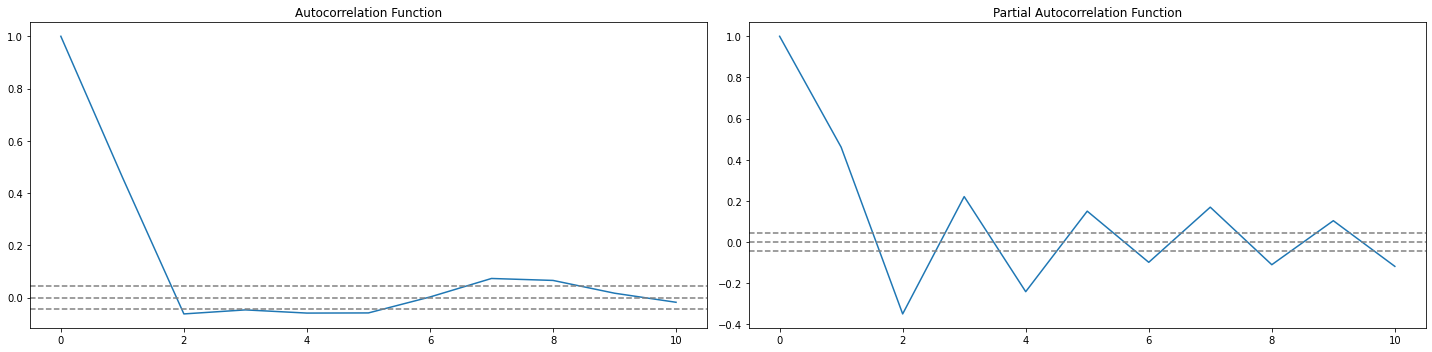

In [0]:
# ACF
lag_acf = acf(train_x_diff, nlags=10)
lag_pacf = pacf(train_x_diff, nlags=10, method='ols')
plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(LVMH['Adj Close'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(LVMH['Adj Close'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(LVMH['Adj Close'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(LVMH['Adj Close'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [0]:
# Critères d'infromations
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
 
# I de ARIMA = 0 car série déjà différenciée
model = ARIMA(train_x_diff, order = (1,0,2))
results_ARIMA = model.fit()
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 2041
Model:                     ARMA(1, 2)   Log Likelihood                5626.767
Method:                       css-mle   S.D. of innovations              0.015
Date:                Mon, 04 May 2020   AIC                         -11243.534
Time:                        11:20:20   BIC                         -11215.428
Sample:                             0   HQIC                        -11233.225
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0015      0.001      2.459      0.014       0.000       0.003
ar.L1.Adj Close     0.6230      0.149      4.182      0.000       0.331       0.915
ma.L1.Adj Close     0.3278      

# **Entraînement**

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


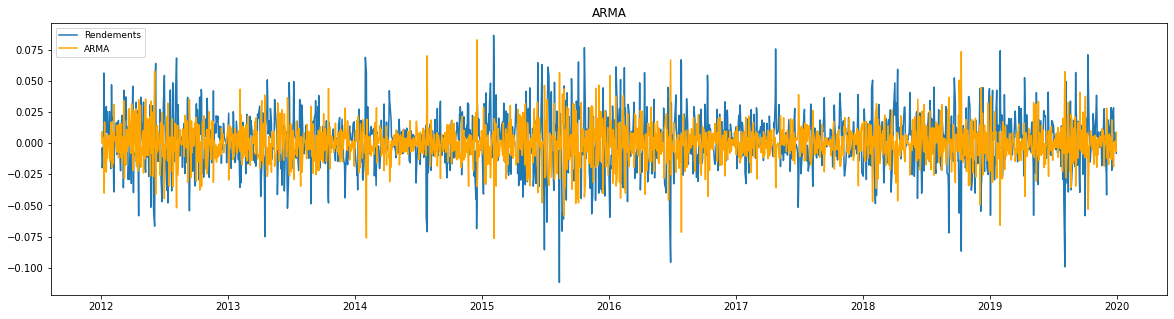

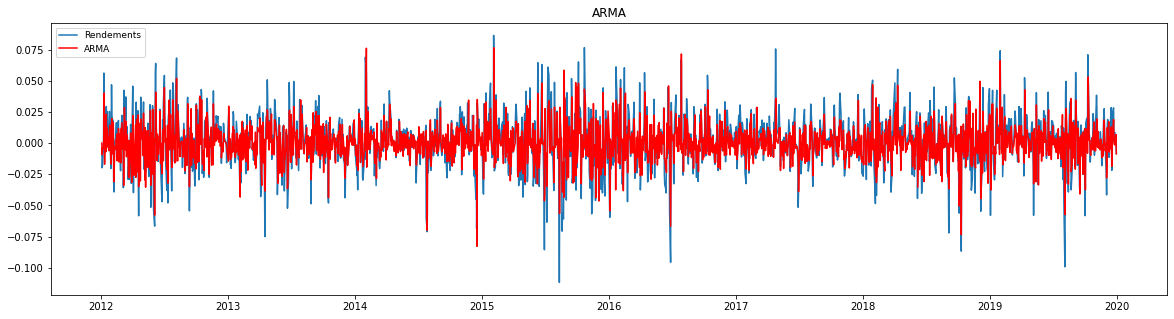

In [0]:
# Entrainement du modèle
# Différenciation d'ordre 2 car serie loguée de base
model = ARIMA(serie_ln, order=(1, 2, 2))  
results_ARIMA = model.fit()  

# Graph
plt.figure(figsize=(20,5))
plt.plot(Date[1:len(Date)], train_x_diff, label='Rendements')
plt.plot(Date[1:len(Date)], results_ARIMA.fittedvalues, label='ARMA', color='orange')
plt.legend(loc='best', fontsize=9)
plt.title('ARMA')
plt.show()

# Opposée
plt.figure(figsize=(20,5))
plt.plot(Date[1:len(Date)], train_x_diff, label='Rendements')
plt.plot(Date[1:len(Date)], -1*results_ARIMA.fittedvalues, label='ARMA', color='red')
plt.legend(loc='best', fontsize=9)
plt.title('ARMA')
plt.show()

# **Prédictions**

In [0]:
# Prédictions sur les 20% du sous-jeu test
y_pred_ARMA = results_ARIMA.predict(start=training_data_len, end=len(data))
y_pred_ARMA = -1 * y_pred_ARMA

In [0]:
# Valeurs échelonnées
scaled_data_ar = pd.DataFrame(scaled_data)
scaled_data_ar.rename(columns={0:'Vraies valeurs scaled'}, inplace=True)
scaled_data_ar = scaled_data_ar[training_data_len:]

In [0]:
# Re-coloration des résultats
for i in range(training_data_len+1,len(y_pred_ARMA)):
    y_pred_ARMA[i] = y_pred_ARMA[i] + scaled_data_ar.iloc[training_data_len + i -1]

scaled_data_ar['Valeurs modifiées']=train_x_diff[training_data_len:]
scaled_data_ar['Predictions']=y_pred_ARMA

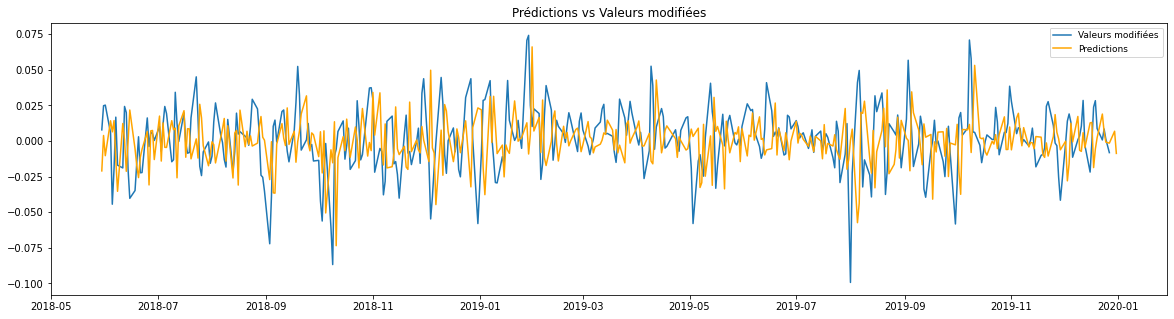

In [0]:
# Graph de prédictions vs Valeurs de la série stationnaire
plt.figure(figsize=(20,5))
plt.plot(Date[training_data_len-1:,], scaled_data_ar['Valeurs modifiées'], label='Valeurs modifiées')
plt.plot(Date[training_data_len-1:,], scaled_data_ar['Predictions'], label='Predictions', color='orange')
plt.legend(loc='best', fontsize=9)
plt.title('Prédictions vs Valeurs modifiées')
plt.show()

In [0]:
# RMSE sur série sationnaire
rmse=np.sqrt(np.mean(scaled_data_ar['Predictions']-scaled_data_ar['Valeurs modifiées'])**2)
rmse

0.0018860739074572444

In [0]:
# Recoloration des résultats:
y_pred_recolor=y_pred_ARMA+shift(serie_ln[training_data_len-1:], n_diff, cval=np.nan)
y_pred_recolor=np.exp(y_pred_recolor)
y_pred_recolor

1635           NaN
1636           NaN
1637    283.906035
1638    292.659938
1639    287.969826
           ...    
2039    404.936989
2040    407.902970
2041    411.624407
2042    405.262396
2043    411.279419
Length: 409, dtype: float64

In [0]:
# RMSE après recoloration des résultats (c'est à dire par rapport aux vraies valeurs)
rmse=np.sqrt(np.mean(y_pred_recolor-LVMH['Adj Close'][training_data_len-1:])**2)
rmse

0.9471033354974655

# SPREAD

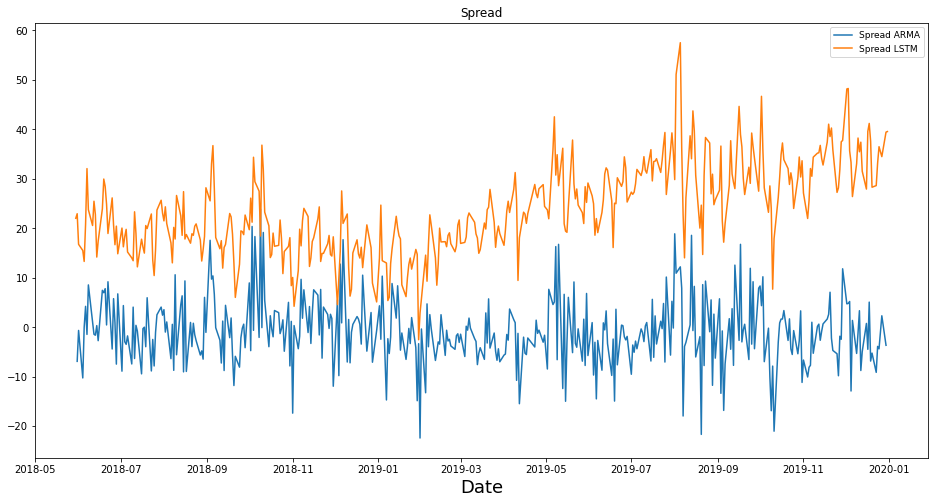

In [0]:
# Erreur: spread entre prdicitions et vrais valeurs
spread_ARMA=y_pred_recolor-LVMH['Adj Close'][training_data_len-1:]
plt.figure(figsize=(16,8))
plt.title('Spread')
plt.xlabel('Date', fontsize=18)
plt.plot(LVMH['Date'][training_data_len-2:],spread_ARMA, label='Spread ARMA')
plt.plot(LVMH['Date'][training_data_len:],spread_LSTM,label='Spread LSTM')
plt.legend(loc='best', fontsize=9)

plt.show()